SVM for baseline performance on image classification

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
import os
import glob
import tqdm
import features_util
import seaborn as sn

In [3]:
train_path = "../../project-data/train_another/"
val_path = "../../project-data/validation_another/"
test_path = "../../project-data/test_another/"
img_size = 128
nchannels = 3

npz_file_listing_train = list(glob.glob(os.path.join(train_path, '**/*.npz')))
npz_file_listing_val = list(glob.glob(os.path.join(val_path, '**/*.npz')))
npz_file_listing_test = list(glob.glob(os.path.join(test_path, '**/*.npz')))
N_train = len(npz_file_listing_train)
N_val = len(npz_file_listing_val)
N_test = len(npz_file_listing_test)

training_data_X = np.zeros((N_train, img_size, img_size, nchannels))
training_data_y = np.zeros(N_train)
val_data_X = np.zeros((N_val, img_size, img_size, nchannels))
val_data_y = np.zeros(N_val)
test_data_X = np.zeros((N_test, img_size, img_size, nchannels))
test_data_y = np.zeros(N_test)

it = 0
for npz_file in tqdm.tqdm(npz_file_listing_train):
    training_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        training_data_y[it] = 0
    else:
        training_data_y[it] = 1
    it += 1
    
it = 0
for npz_file in tqdm.tqdm(npz_file_listing_val):
    val_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        val_data_y[it] = 0
    else:
        val_data_y[it] = 1
    it += 1
    
it = 0
for npz_file in tqdm.tqdm(npz_file_listing_test):
    test_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        test_data_y[it] = 0
    else:
        test_data_y[it] = 1
    it += 1

100%|██████████| 9000/9000 [00:33<00:00, 267.55it/s]


labels: (array([0., 1.]), array([5000, 5000]))


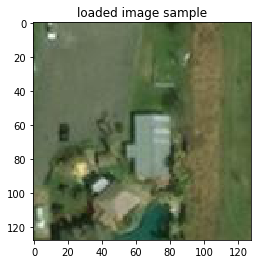

In [4]:
# check to see if this worked
print("labels:", np.unique(training_data_y, return_counts=True))
single_im = training_data_X[9, :, :, :]
plt.imshow(single_im/255)
plt.title("loaded image sample")
plt.show()
# cool, yup!

In [9]:
# generate sample data
N_train = 2000
sample_idx = np.random.randint(0, training_data_X.shape[0], size=N_train)

sample_X_train = training_data_X[sample_idx,:,:,:]
sample_y_train = training_data_y[sample_idx]

N_val = 1000
sample_idx_val = np.random.randint(0, val_data_X.shape[0], size=N_val)

sample_X_val = val_data_X[sample_idx_val,:,:,:]
sample_y_val = val_data_y[sample_idx_val]

In [10]:
# working with transformed data
# fourier transform
X_dft_train = features_util.dft_features(sample_X_train)
X_dft_val = features_util.dft_features(sample_X_val)

# wavelet transform
X_dwt_train = features_util.wavelet_features(sample_X_train)
X_dwt_val = features_util.wavelet_features(sample_X_val)

# pca dimensionality reduction
pca_X_train_proj, pca_components_train = features_util.pca_features(sample_X_train)
pca_X_val_proj, pca_components_val = features_util.pca_features(sample_X_val)

  1%|          | 22/2000 [00:00<00:09, 212.40it/s]

generating dft features


  3%|▎         | 28/1000 [00:00<00:03, 269.51it/s]

generating dft features


  1%|          | 22/2000 [00:00<00:09, 216.06it/s]

generating wavelet features


  6%|▌         | 55/1000 [00:00<00:01, 544.37it/s]

generating wavelet features


100%|██████████| 1000/1000 [00:01<00:00, 604.08it/s]


In [13]:
pca_dim = pca_components_train[0].shape[1]
X_pca_train = np.zeros(N_train, pca_dim, nchannels)
X_pca_val = np.zeros(N_train)
for i in range(nchannels):
    X_pca_train[:,:,i] = pca_components_train[i]

(2000, 174)

In [18]:
# in order to train an SVM, I want to reshape the data so it's in the form (nsamples, nfeatures)
N_features = img_size * img_size * nchannels
X_train_reshape = np.reshape(sample_X_train, (N_train, N_features))
X_train_dft_reshape = np.reshape(X_dft_train, (N_train, N_features))
X_train_dwt_reshape = np.reshape(X_dwt_train, (N_train, N_features))

X_val_reshape = np.reshape(sample_X_val, (N_val, N_features))
X_val_dft_reshape = np.reshape(X_dft_val, (N_val, N_features))
X_val_dwt_reshape = np.reshape(X_dwt_val, (N_val, N_features))

**Linear SVM** with raw data

In [19]:
# now let's train a support vector machine with just the raw data as inputs
raw_svm_lin = svm.SVC(kernel='linear', verbose=True)
raw_svm_lin.fit(X_train_reshape, sample_y_train)

y_pred = raw_svm_lin.predict(X_train_reshape)
train_acc = np.sum(y_pred == sample_y_train)/sample_y_train.shape[0]

y_val_pred = raw_svm_lin.predict(X_val_reshape)
val_acc = np.sum(y_val_pred == sample_y_val)/sample_y_val.shape[0]

print("Training accuracy:", train_acc)
print("Validation accuracy:", val_acc)

[LibLinear]

/Users/nataliegable/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training accuracy: 1.0
Validation accuracy: 0.642


**Linear SVM** with DFT data

In [20]:
dft_svm_lin = svm.SVC(kernel="linear", verbose=True)
dft_svm_lin.fit(X_train_dft_reshape, sample_y_train)

y_pred_dft = dft_svm_lin.predict(X_train_dft_reshape)
train_acc_dft = np.sum(y_pred_dft == sample_y_train)/sample_y_train.shape[0]

y_val_pred_dft = dft_svm_lin.predict(X_val_dft_reshape)
val_acc_dft = np.sum(y_val_pred_dft == sample_y_val)/sample_y_val.shape[0]

print("Training accuracy:", train_acc_dft)
print("Validation accuracy:", val_acc_dft)

[LibLinear]

/Users/nataliegable/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training accuracy: 0.9965
Validation accuracy: 0.633


**Linear SVM** with Wavelet data

In [21]:
dwt_svm_lin = svm.SVC(kernel="linear", verbose=True)
dwt_svm_lin.fit(X_train_dwt_reshape, sample_y_train)

y_pred_dwt = dwt_svm_lin.predict(X_train_dwt_reshape)
train_acc_dwt = np.sum(y_pred_dwt == sample_y_train)/sample_y_train.shape[0]

y_val_pred_dwt = dwt_svm_lin.predict(X_val_dwt_reshape)
val_acc_dwt = np.sum(y_val_pred_dwt == sample_y_val)/sample_y_val.shape[0]

print("Training accuracy:", train_acc_dwt)
print("Validation accuracy:", val_acc_dwt)

[LibSVM]Training accuracy: 1.0
Validation accuracy: 0.692


**Confusion Matrices for the above 3**

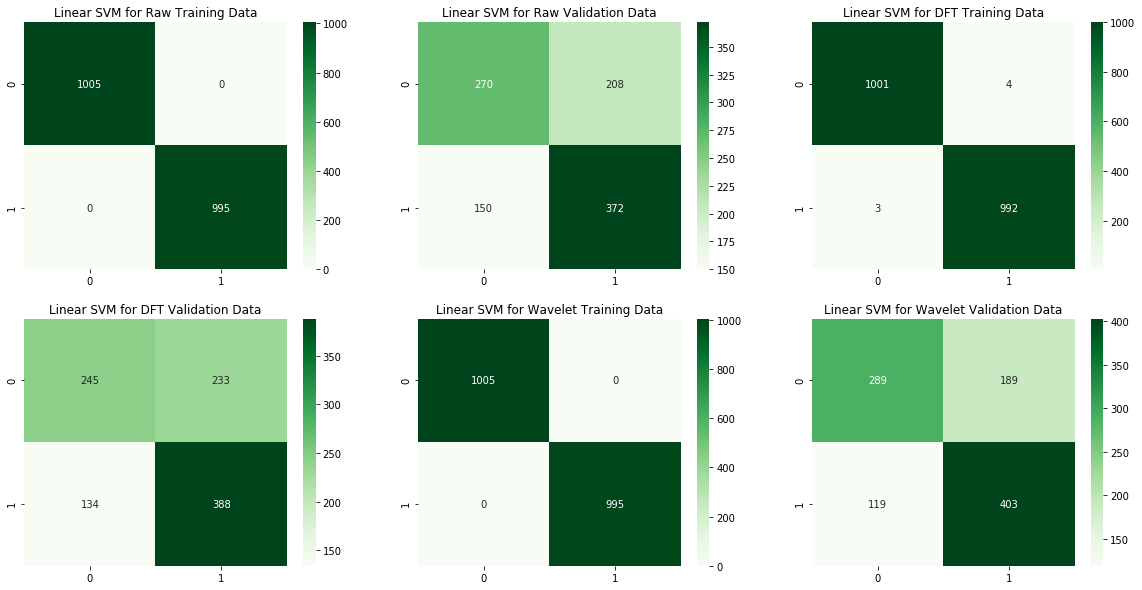

In [35]:
raw_lin_conf_train = metrics.confusion_matrix(sample_y_train, y_pred)
raw_lin_conf_val = metrics.confusion_matrix(sample_y_val, y_val_pred)
dft_lin_conf_train = metrics.confusion_matrix(sample_y_train, y_pred_dft)
dft_lin_conf_val = metrics.confusion_matrix(sample_y_val, y_val_pred_dft)
dwt_lin_conf_train = metrics.confusion_matrix(sample_y_train, y_pred_dwt)
dwt_lin_conf_val = metrics.confusion_matrix(sample_y_val, y_val_pred_dwt)
conf_mat_raw = [raw_lin_conf_train, raw_lin_conf_val, dft_lin_conf_train, dft_lin_conf_val, dwt_lin_conf_train, dwt_lin_conf_val]
conf_mat_titles = [
    "Linear SVM for Raw Training Data", 
    "Linear SVM for Raw Validation Data", 
    "Linear SVM for DFT Training Data", 
    "Linear SVM for DFT Validation Data", 
    "Linear SVM for Wavelet Training Data", 
    "Linear SVM for Wavelet Validation Data",    
]
plt.figure(figsize = (20,10))
for i in range(6):
    plt.subplot(230 + i + 1)
    sn.heatmap(conf_mat_raw[i], annot=True, fmt='g', cmap='Greens')
    plt.title(conf_mat_titles[i])

**Kernelized SVM** with raw data

Trying out RBF kernel.

**RBF Kernelized SVM** with raw data

In [36]:
raw_svm_rbf = svm.SVC(kernel='rbf', verbose=True)
raw_svm_rbf.fit(X_train_reshape, sample_y_train)

y_pred = raw_svm_rbf.predict(X_train_reshape)
train_acc = np.sum(y_pred == sample_y_train)/sample_y_train.shape[0]

y_val_pred = raw_svm_rbf.predict(X_val_reshape)
val_acc = np.sum(y_val_pred == sample_y_val)/sample_y_val.shape[0]

print("Training accuracy:", train_acc)
print("Validation accuracy:", val_acc)

[LibSVM]Training accuracy: 0.9275
Validation accuracy: 0.777


**RBF Kernelized SVM** with DFT data

In [37]:
dft_svm_rbf = svm.SVC(kernel="rbf", verbose=True)
dft_svm_rbf.fit(X_train_dft_reshape, sample_y_train)

y_pred_dft = dft_svm_rbf.predict(X_train_dft_reshape)
train_acc_dft = np.sum(y_pred_dft == sample_y_train)/sample_y_train.shape[0]

y_val_pred_dft = dft_svm_rbf.predict(X_val_dft_reshape)
val_acc_dft = np.sum(y_val_pred_dft == sample_y_val)/sample_y_val.shape[0]

print("Training accuracy:", train_acc_dft)
print("Validation accuracy:", val_acc_dft)

[LibSVM]Training accuracy: 0.777
Validation accuracy: 0.73


**RBF Kernelized SVM** with wavelet data

In [38]:
dwt_svm_rbf = svm.SVC(kernel="rbf", verbose=True)
dwt_svm_rbf.fit(X_train_dwt_reshape, sample_y_train)

y_pred_dwt = dwt_svm_rbf.predict(X_train_dwt_reshape)
train_acc_dwt = np.sum(y_pred_dwt == sample_y_train)/sample_y_train.shape[0]

y_val_pred_dwt = dwt_svm_rbf.predict(X_val_dwt_reshape)
val_acc_dwt = np.sum(y_val_pred_dwt == sample_y_val)/sample_y_val.shape[0]

print("Training accuracy:", train_acc_dwt)
print("Validation accuracy:", val_acc_dwt)

[LibSVM]Training accuracy: 0.817
Validation accuracy: 0.749


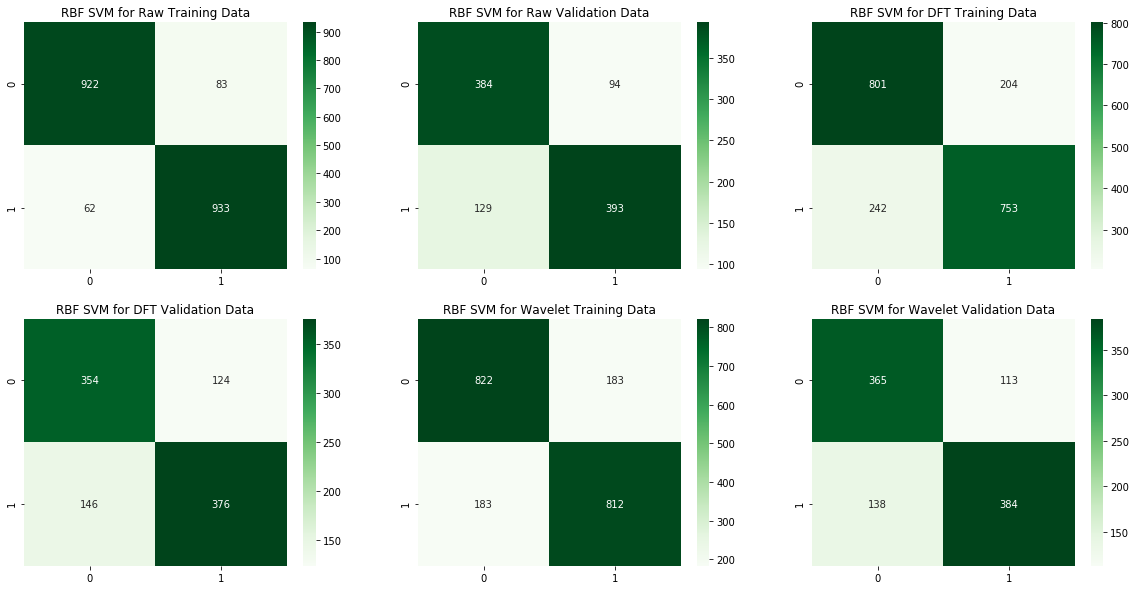

In [39]:
raw_lin_conf_train = metrics.confusion_matrix(sample_y_train, y_pred)
raw_lin_conf_val = metrics.confusion_matrix(sample_y_val, y_val_pred)
dft_lin_conf_train = metrics.confusion_matrix(sample_y_train, y_pred_dft)
dft_lin_conf_val = metrics.confusion_matrix(sample_y_val, y_val_pred_dft)
dwt_lin_conf_train = metrics.confusion_matrix(sample_y_train, y_pred_dwt)
dwt_lin_conf_val = metrics.confusion_matrix(sample_y_val, y_val_pred_dwt)
conf_mat_raw = [raw_lin_conf_train, raw_lin_conf_val, dft_lin_conf_train, dft_lin_conf_val, dwt_lin_conf_train, dwt_lin_conf_val]
conf_mat_titles = [
    "RBF SVM for Raw Training Data", 
    "RBF SVM for Raw Validation Data", 
    "RBF SVM for DFT Training Data", 
    "RBF SVM for DFT Validation Data", 
    "RBF SVM for Wavelet Training Data", 
    "RBF SVM for Wavelet Validation Data",    
]
plt.figure(figsize = (20,10))
for i in range(6):
    plt.subplot(230 + i + 1)
    sn.heatmap(conf_mat_raw[i], annot=True, fmt='g', cmap='Greens')
    plt.title(conf_mat_titles[i])